# Test Runner


### Imports

In [1]:
import os

# os.environ["OPENBLAS_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.runner import Runner
from pcntoolkit.regression_model.hbr.param import Param
import seaborn as sns
import arviz as az
import multiprocessing as mp


mp.set_start_method("spawn")


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

In [3]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

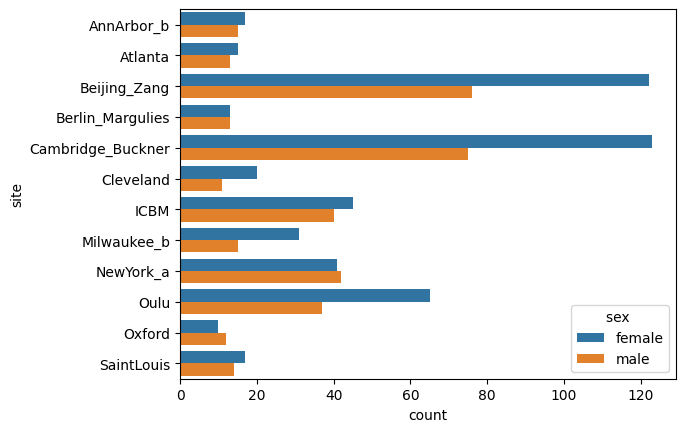

In [4]:
# Group the data by site and sex
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore

# Get the sites with only one sex present
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index

# remove the sites with less than 10 samples
data = data[~data["site"].isin(sites_with_one_sex.index)]


# find the sites that have less than 10 samples
site_counts = site_counts[site_counts["counts"] < 10]

# remove the sites with less than 10 samples
data = data[~data["site"].isin(site_counts["site"])]

sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

We find the seven largest sites, which we will use for train and transfer. Two of those are randomly selected for transfering later.

In [5]:
site_counts = data.groupby(["site"]).size().reset_index(name="counts")  # type: ignore
site_counts = site_counts.sort_values("counts", ascending=False)
site_counts = site_counts.head(7)
display(site_counts)

np.random.seed(45)
# randomly select 2 sites from the top 7 sites for transfering
transfer_sites = site_counts.sample(2)["site"]
display(transfer_sites)
transfer_data = data[data["site"].isin(transfer_sites)]

# The remaining sites are used for training the model
fit_sites = site_counts[~site_counts.isin(transfer_sites)]["site"]
fit_sites.dropna(inplace=True)
display(fit_sites)
fit_data = data[data["site"].isin(fit_sites)]

,site,counts
2,Beijing_Zang,198
4,Cambridge_Buckner,198
9,Oulu,102
6,ICBM,85
8,NewYork_a,83
7,Milwaukee_b,46
0,AnnArbor_b,32


7    Milwaukee_b
9           Oulu
Name: site, dtype: object

2         Beijing_Zang
4    Cambridge_Buckner
6                 ICBM
8            NewYork_a
0           AnnArbor_b
Name: site, dtype: object

Next, we load the data into `NormData` objects. All functions in the PCNtoolkit expect the data to be provided as instances of the `NormData` class. The class manages all preprocessing, basis expansions, and dimensions. 

In [6]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]

# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(
    name="fit",  # name of the dataset
    dataframe=fit_data,  # pandas dataframe
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Create a transfer data object from the downloaded data
transfer_data = NormData.from_dataframe(
    name="transfer",
    dataframe=transfer_data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)


## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [7]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    save_dir="/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir",
    log_dir="/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/log_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    order=3,
    nknots=5,
)

Configuration of normative model is valid.


/opt/anaconda3/envs/dev_runner/lib/python3.12/site-packages/pcntoolkit/normative_model/norm_conf.py:173: UserWarning: save_dir (/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir) does not exist, creating it for you
  warnings.warn(


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [8]:
blr_conf = BLRConf(
    intercept=True,
    random_intercept=False,
    heteroskedastic=False,
    intercept_var=False,
    n_iter=1000,
)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [9]:
# Using the constructor
norm_hbr = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)
display(norm_hbr)
del norm_hbr

In [10]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, blr_conf)
norm_hbr

## Create a runner

In [11]:
runner = Runner(
    norm_hbr,
    cross_validate=True,
    cv_folds=2,
    parallelize=True,
    cluster_type="local",
    n_jobs=1,
)

In [12]:
runner.fit(normdata)

7020 Going to fit 2 models
7020 Fitting model for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_runner/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr_data.py:88: UserWarning: var_X is not provided, setting self.var_X to zeros
  warnings.warn("var_X is not provided, setting self.var_X to zeros")


7020 A
